# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> IMT 2200 - Introducción a Ciencia de Datos
**Pontificia Universidad Católica de Chile**<br>
**Semestre 2021-1**<br>
**Profesora:** Paula Aguirre <br>

## Clase 18: Regresión lineal.

---

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Displays the plots for us.
%matplotlib inline

##  1. Regresión Lineal Simple con `statsmodels` y `scipy`

Para implementar regresiones lineales y predecir los outcomes para distintas variables de entrada, podemos usar distintas librerías de `python`:

* [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html).
* [statsmodels](http://www.statsmodels.org/stable/regression.html) y 
* [scikit-learn (sklearn)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).


Para efectos de regresiones lineales simples,`scipy`, `statsmodels` y `sklearn` hacen lo mismo. Más en general,  `statsmodels` tiende a ser más fácil para problemas de inferencia (econtrar los parámetros de la regresión y analizar sus incertezas) mientras que  `sklearn` tiene un enfoque de machine learning y es más práctico para realizar predicciones.


### Caso de Estudio.

Para este ejercicio, tenemos como ejemplo un dataset con datos de automóviles, extraidos del repositorio UCI Machine Learning Repository:

https://archive.ics.uci.edu/ml/datasets/auto+mpg


*The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)* <br>

Los datos incluyen datos sobre características del diseño e ingeniería de distintos modelos de autos, como se describe a continuación:

- `mpg`: rendimiento de combustible en millas/galón. 
- `cylinders`: número de cilindros. is Number of cylinders, 
- `displacement`: desplazamiento (cu.in.), 
- `horsepower`: potencia en "caballos de fuerza". 
- `drat`: razón de eje trasero. 
- `weight`: peso (en miles de libras).
- `acceleration`: tiempo en recorrer 1/4 de milla desde el reposo.
- `origin`: origen 
- `car name`: nombre del modelo 


El objetivo es predecir el consumo de un vehículo, en función de sus parámetros de diseño e ingeniería. 


### 1.1 Explore los datos y las posibles relaciones entre las variables que caracterizan un auto, y su consumo de combustible.

In [7]:
#load mtcars
dfcars = pd.read_csv("auto-mpg.csv")
dfcars.dropna(axis=0,inplace=True)
dfcars

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [34]:
dfcars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   mpg           392 non-null    float64 
 1   cylinders     392 non-null    category
 2   displacement  392 non-null    float64 
 3   horsepower    392 non-null    float64 
 4   weight        392 non-null    int64   
 5   acceleration  392 non-null    float64 
 6   model year    392 non-null    int64   
 7   origin        392 non-null    category
 8   car name      392 non-null    category
dtypes: category(3), float64(4), int64(2)
memory usage: 33.8 KB


In [27]:
dfcars=dfcars[dfcars['horsepower']!='?']

In [28]:
dfcars['origin']=dfcars['origin'].astype('category')
dfcars['car name']=dfcars['car name'].astype('category')
dfcars['cylinders']=dfcars['cylinders'].astype('category')
dfcars['horsepower']=dfcars['horsepower'].astype('float')

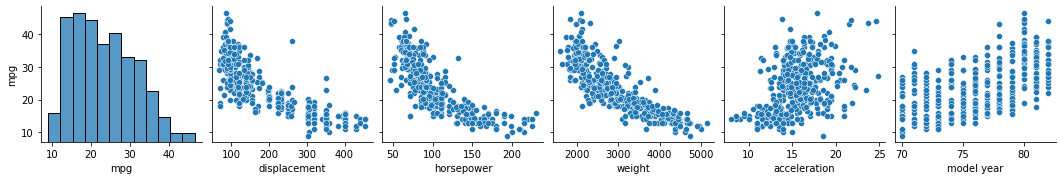

In [29]:
sns.pairplot(dfcars,y_vars='mpg');

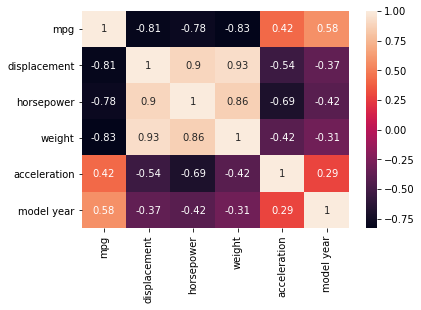

In [30]:
sns.heatmap(dfcars.corr(),annot=True);

#### Exploremos los datos: ¿cuál es el rendimiento promedio para distintas combinaciones de cilindros y hp?

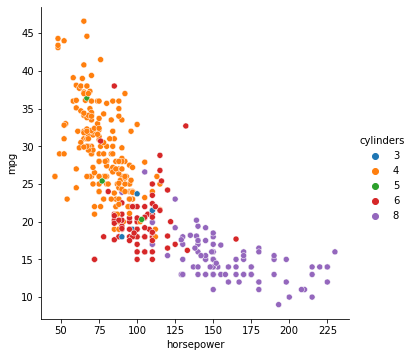

In [32]:
sns.pairplot(data=dfcars,y_vars='mpg',x_vars='horsepower',hue='cylinders',size=5);

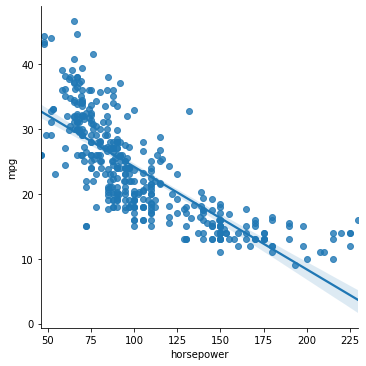

In [35]:
sns.lmplot(data=dfcars,y='mpg',x='horsepower');

### 1.2 Use `statsmodel` para ajustar los datos de entrenamiento usando una regresión lineal simple. 

- Nota sobre constantes:

Supongamos un caso sencillo, en que tenemos 2 observaciones con un predictor y una variable de respuesta cada una. Tendríamos por lo tanto el siguiente sistema de ecuaciones para el modelo de regresión lineal simple:
 $$y_1=\beta_0 + \beta_1\cdot x_1$$ $$y_2=\beta_0 + \beta_1\cdot x_2$$ <BR>
    
En notación matricial, esto sería: 
    
$$
\left [
\begin{array}{c}
y_1 \\ y_2 \\
\end{array}
\right] =
\left [
\begin{array}{cc}
1& x_1 \\ 1 & x_2 \\
\end{array}
\right] 
\cdot
\left [
\begin{array}{c}
\beta_0 \\ \beta_1 \\
\end{array}
\right]
$$
<BR><BR>
    
`sklearn` agrega automáticamente la constante `1`, mientras que en  `statsmodels` hay que agregarla explícitamente usando `sm.add_constant`

In [39]:
x = np.array(dfcars.horsepower)
y = np.array(dfcars.mpg)

In [40]:
import statsmodels.api as sm

# create the X matrix by appending a column of ones to x_train
X = sm.add_constant(x)

In [43]:
# build the OLS model (ordinary least squares) from the training data
regr_sm = sm.OLS(y, X)

# do the fit and save regression info (parameters, etc) in results_sm
results_sm = regr_sm.fit()

results_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           7.03e-81
Time:                        09:35:56   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000      38.525      41.347
x1            -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# cpeficientes beta
beta0 = results_sm.params[0]
beta1 = results_sm.params[1]


### 1.3 Grafique los datos y las predicciones.

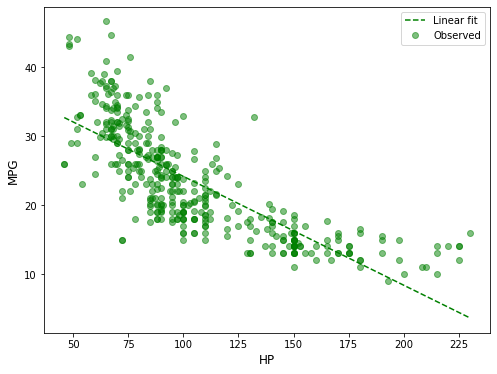

In [49]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

grid = np.linspace(np.min(dfcars.horsepower), np.max(dfcars.horsepower), 100)

y_fit=beta0+beta1*grid

ax.plot(grid,y_fit, '--',color='g',label='Linear fit')

ax.plot(dfcars.horsepower,dfcars.mpg, 'o',color='g',alpha=0.5,label='Observed') 

ax.set_xlabel("HP", fontsize=12)
ax.set_ylabel("MPG", fontsize=12)
ax.legend();

Lo mismo para la variable `weight`:

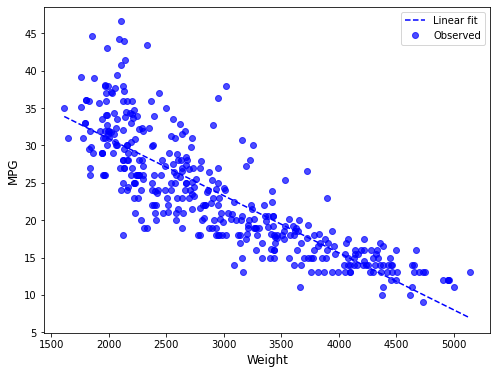

In [50]:
x = np.array(dfcars.weight)
y = np.array(dfcars.mpg)

X = sm.add_constant(x)

regr_sm = sm.OLS(y, X)
results_sm = regr_sm.fit()

beta0 = results_sm.params[0]
beta1 = results_sm.params[1]

fig, ax = plt.subplots(1,1, figsize=(8,6))
grid = np.linspace(np.min(dfcars.weight), np.max(dfcars.weight), 100)
y_fit_lineal=beta0+beta1*grid

ax.plot(grid,y_fit_lineal, '--',color='b',label='Linear fit')

ax.plot(dfcars.weight,dfcars.mpg, 'o',color='b',alpha=0.7,label='Observed') 

ax.set_xlabel("Weight", fontsize=12)
ax.set_ylabel("MPG", fontsize=12)
ax.legend()

In [51]:
results_sm.rsquared

0.6926304331206254

## 2. Regresión  Polinomial.

En una regresión polinomial, usamos un **modelo lineal** para estimar una **función no lineal** (i.e., una función con términos polinomiales). Por ejemplo, 

$y = \beta_0 + \beta_1x_i + \beta_2x_i^{2}$

Es un modelo _lineal_ porque resolvemos una ecuación lineal para obtener los coeficientes $\beta$.


In [52]:
import statsmodels.formula.api as smf
#¿Es un buen ajuste? tal vez podemos probar con una funcion no lineal

dfcars['wt2']=dfcars['weight']**2

# Calcular regresión lineal con 
lm1 = smf.ols('mpg ~ weight + wt2', data=dfcars).fit()

# Print the estimated parameters
print(lm1.params,lm1.rsquared)
lm1.summary()

Intercept    62.255474
weight       -0.018496
wt2           0.000002
dtype: float64 0.7151475557845139


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     488.3
Date:                Tue, 18 Oct 2022   Prob (F-statistic):          8.39e-107
Time:                        09:38:09   Log-Likelihood:                -1115.1
No. Observations:                 392   AIC:                             2236.
Df Residuals:                     389   BIC:                             2248.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.2555      2.993     20.800      0.000      56.371      68.140
weight        -0.0185      0.002     -9.379      0.000      -0.022      -0.015
wt2         1.697e-06   3.06e-07      5.545      0.000     1.1e-06     2.3e-06
==============================================================================
Omnibus:                       53.804   Durbin-Watson:                   0.770
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.923
Skew:                           0.809   Prob(JB):                     4.03e-21
Kurtosis:                       4.770   Cond. No.                     1.57e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

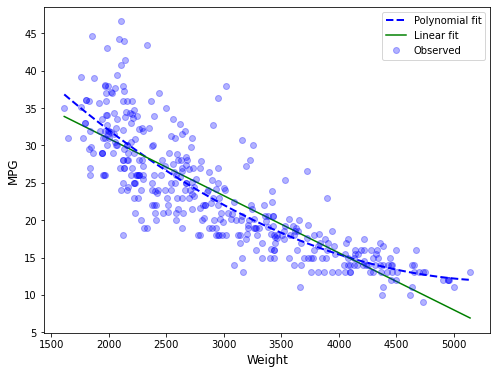

In [57]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

xgrid = np.linspace(np.min(dfcars.weight), np.max(dfcars.weight), 100)

y_fit_poly=lm1.params[0]+lm1.params[1]*xgrid+lm1.params[2]*xgrid**2

ax.plot(xgrid,y_fit_poly, '--',color='b',label='Polynomial fit',lw=2)
ax.plot(grid,y_fit_lineal, '-',color='green',label='Linear fit')

ax.plot(dfcars.weight,dfcars.mpg, 'o',color='b',alpha=0.3,label='Observed') 

ax.set_xlabel("Weight", fontsize=12)
ax.set_ylabel("MPG", fontsize=12)
ax.legend();

In [58]:
from sklearn.metrics import mean_squared_error

y_predict_lin=beta0+beta1*x
print('MSE lineal:',mean_squared_error(y, y_predict_lin))


y_predict_poly=lm1.params[0]+lm1.params[1]*x+lm1.params[2]*x**2
print('MSE poly:',mean_squared_error(y, y_predict_poly))



MSE lineal: 18.6766165974193
MSE poly: 17.308414562519907


## 3. Regresión multilineal.

Supongamos ahora un modelo incluyendo múltiples variables:

$$\text{mpg} \approx \beta_0 + \beta_1\text{disp} + \beta_2\text{hp} + \beta_3\text{wt} +\beta_4\text{wt}^2 $$


In [60]:
import statsmodels.formula.api as smf
dfcars = pd.read_csv("auto-mpg.csv")
dfcars.dropna(axis=0,inplace=True)
dfcars=dfcars[dfcars['horsepower']!='?']
dfcars['origin']=dfcars['origin'].astype('category')
dfcars['car name']=dfcars['car name'].astype('category')
dfcars['cylinders']=dfcars['cylinders'].astype('category')
dfcars['horsepower']=dfcars['horsepower'].astype('float')

dfcars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [63]:
def build_xmatrix(df,columns,cols_squared=[]):
    x_matrix = df[columns].copy()
    
    for col in cols_squared:
        x_matrix['%s_2'%col] = df[col]**2
    
    x_matrix = sm.add_constant(x_matrix)
    return(x_matrix)

In [64]:
columns=['displacement','horsepower','weight']
cols_squared=['weight']

x_matrix=build_xmatrix(dfcars,columns,cols_squared)
x_matrix.head()

,const,displacement,horsepower,weight,weight_2
0,1.0,307.0,130.0,3504,12278016
1,1.0,350.0,165.0,3693,13638249
2,1.0,318.0,150.0,3436,11806096
3,1.0,304.0,150.0,3433,11785489
4,1.0,302.0,140.0,3449,11895601


In [65]:
import statsmodels.api as sm
from statsmodels.api import OLS

y=dfcars.mpg
fitted_model= OLS(y, x_matrix, hasconst=True).fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     271.9
Date:                Tue, 18 Oct 2022   Prob (F-statistic):          5.39e-111
Time:                        09:42:12   Log-Likelihood:                -1099.0
No. Observations:                 392   AIC:                             2208.
Df Residuals:                     387   BIC:                             2228.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           63.9161      3.054     20.929      0.000      57.912      69.920
displacement    -0.0046      0.006     -0.732      0.465      -0.017       0.008
horsepower      -0.0566      0.012     -4.583      0.000      -0.081      -0.032
weight          -0.0178      0.002     -9.029      0.000      -0.022      -0.014
weight_2      2.017e-06      3e-07      6.721      0.000    1.43e-06    2.61e-06
==============================================================================
Omnibus:                       45.681   Durbin-Watson:                   0.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.077
Skew:                           0.736   Prob(JB):                     1.35e-16
Kurtosis:                       4.519   Cond. No.                     1.66e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

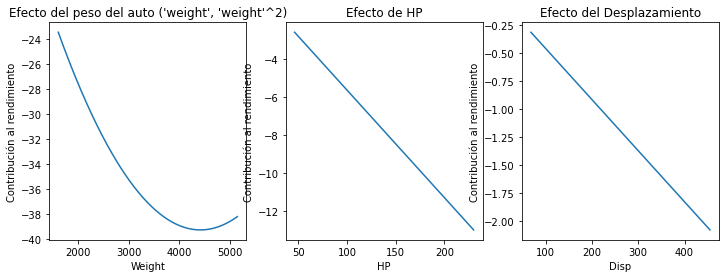

In [68]:
fig=plt.figure(figsize=(12,4))

x_wt = np.arange(dfcars['weight'].min(),dfcars['weight'].max(),0.01)
wtcoef = fitted_model.params.weight
wt2coef = fitted_model.params.weight_2
y_wt = wtcoef*x_wt +wt2coef*x_wt**2

ax1=fig.add_subplot(131)
ax1.plot(x_wt, y_wt)
ax1.set_title("Efecto del peso del auto ('weight', 'weight'^2)")
ax1.set_xlabel("Weight")
ax1.set_ylabel("Contribución al rendimiento")

hpcoef=fitted_model.params.horsepower
x_hp = np.arange(dfcars['horsepower'].min(),dfcars['horsepower'].max(),0.01)
y_hp=hpcoef*x_hp

ax2=fig.add_subplot(132)
ax2.plot(x_hp, y_hp)
ax2.set_title("Efecto de HP")
ax2.set_xlabel("HP")
ax2.set_ylabel("Contribución al rendimiento")

dispcoef=fitted_model.params.displacement
x_disp = np.arange(dfcars['displacement'].min(),dfcars['displacement'].max(),0.01)
y_disp=dispcoef*x_disp

ax3=fig.add_subplot(133)
ax3.plot(x_disp, y_disp)
ax3.set_title("Efecto del Desplazamiento")
ax3.set_xlabel("Disp")
ax3.set_ylabel("Contribución al rendimiento")


plt.show()


